In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import os
import mytools

# Data Handling

In [2]:
# Make custom dataset
#num_sims = int((len(os.listdir('/home/majd/sparse_tensors/'))-1)/3) # -1 because I noticed a .DS_store file was added, /3 
num_sims = 801188
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_tensors/', N_sims=num_sims)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(MyDataset,[0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))
print("Testing samples: ", len(test_dataset))

# Create DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Training samples:  480713
Validation samples:  160238
Testing samples:  160237


In [3]:
# Print tensor shapes
for X_plot, y_plot, idx in test_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("indices: ", idx.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([64, 1, 120, 120, 120])
Shape of y: torch.Size([64, 3]) torch.float32
indices:  torch.Size([64])


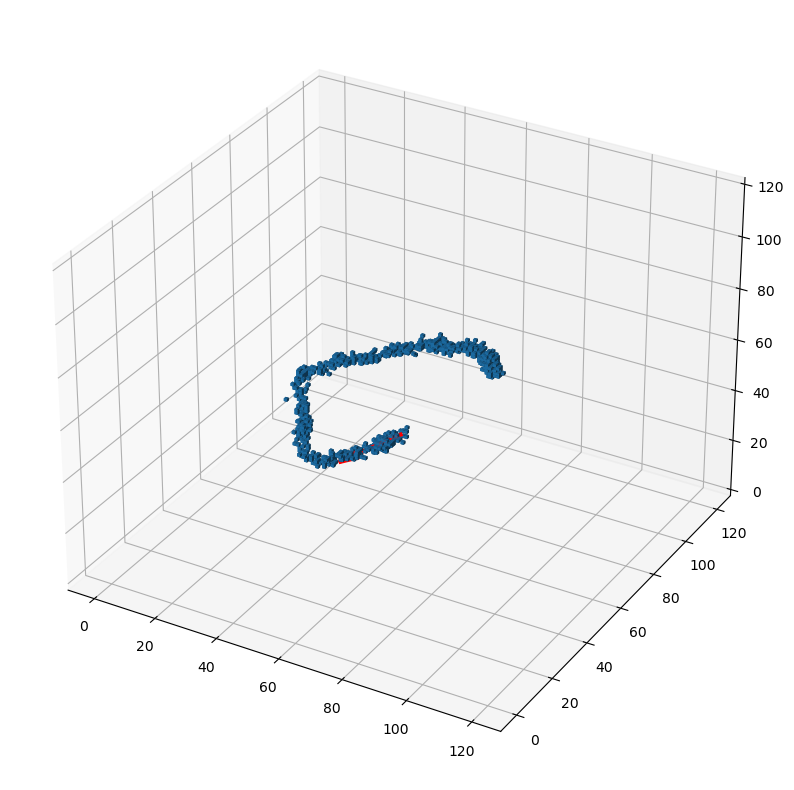

In [4]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05

index = 4
off = torch.load('/home/majd/sparse_tensors/' + 'offset_' + str(idx[index].item()) + '.pt' )
mytools.plot_tensor_dir(tensor = X_plot.to_dense().numpy()[index], start = off, direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)

# Load the models

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1)
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.normalize(self.fc3(x),dim=1)
        return x
    
    
# Define model
class HSCDC_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1)
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2_1 = nn.Linear(100, 30)
        self.fc3_1 = nn.Linear(30, 3)
        self.fc2_2 = nn.Linear(100, 30)
        self.fc3_2 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x1 = torch.tanh(self.fc2_1(x))
        x1 = F.normalize(self.fc3_1(x1),dim=1)
        x2 = F.relu(self.fc2_2(x))
        x2 = F.softplus(self.fc3_2(x2))
        return x1,x2

Using cuda device


In [6]:
CNN = CNN_model().to(device)
HSCDC_CNN = HSCDC_model().to(device)

CNN.load_state_dict(torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN.pth'))
HSCDC_CNN.load_state_dict(torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN.pth'))

<All keys matched successfully>

# Compute Cosine Similarity test loss

In [6]:
# Define validation epoch loop
def test_cossim(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y, index in dataloader:
            X, y = X.type(torch.FloatTensor).to(device), y.to(device)
            
            #convert to dense tensor
            X = X.to_dense()
                        
            pred = model(X)

            val_loss += loss_fn(pred, y).item()
            
    val_loss /= num_batches
    print(f"Test loss: {val_loss:>7f} \n")
    return(val_loss)



In [7]:
# Define Loss functions

CS = nn.CosineSimilarity()
def loss_fn_CNN(output, target):
    loss = torch.mean(-1.0*CS(output,target))
    return loss

def loss_fn_HSCDC(output, target):
    loss = torch.mean(-1.0*CS(output[0],target))
    return loss

In [9]:
test_cossim(test_dataloader,CNN,loss_fn_CNN,device)

Test loss: -0.871666 



-0.8716663812724547

In [10]:
test_cossim(test_dataloader,HSCDC_CNN,loss_fn_HSCDC,device)

Test loss: -0.860809 



-0.8608091666389959